# Mid-LSTM main files
Code editor: Xinyi Li, Yinchuan Li. Date: 2019.2.20.

The code is run on Google's Colaboartory.

Paper: Mid-LSTM meets Mid-ARMA: deep learning for midterm stock prediction.



## Import packages

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/download data/sp500new")
# !ls
from google.colab import files
import os
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Hidden Markov model

In [0]:
class _BaseHMM():
    """
    n_iter : Number of iterations.
    x_size : Observation dimension
    start_prob : Initial probability
    transmat_prob : State transition probability
    """
    __metaclass__ = ABCMeta  # Virtual class declaration

    def __init__(self, n_state=1, x_size=1, iter=20):
        self.n_state = n_state
        self.x_size = x_size
        self.start_prob = np.ones(n_state) * (1.0 / n_state)  # Initial state probability
        self.transmat_prob = np.ones((n_state, n_state)) * (1.0 / n_state)  # State transition probability matrix
        self.trained = False #  Whether need to retrain
        self.n_iter = iter  # Number of iterations of EM training

    # Initialize the transmit parameters
    def _init(self,X):
        pass

    # Virtual function: returning the probability of transmission
    def emit_prob(self, x):  # Find the probability of x emission in state k P(X|Z)
        return np.array([0])

    # Virtual function
    def generate_x(self, z): # Generate observations based on hidden states x p(x|z)
        return np.array([0])

    # Virtual function: update of emission probability
    def emit_prob_updated(self, X, post_state):
        pass

    # Generate sequence by HMM
    def generate_seq(self, seq_length):
        X = np.zeros((seq_length, self.x_size))
        Z = np.zeros(seq_length)
        Z_pre = np.random.choice(self.n_state, 1, p=self.start_prob)  # Sampling initial  state
        X[0] = self.generate_x(Z_pre) # Sampling to get the first value of the sequence
        Z[0] = Z_pre

        for i in range(seq_length):
            if i == 0: continue
            # P(Zn+1)=P(Zn+1|Zn)P(Zn)
            Z_next = np.random.choice(self.n_state, 1, p=self.transmat_prob[Z_pre,:][0])
            Z_pre = Z_next
            # P(Xn+1|Zn+1)
            X[i] = self.generate_x(Z_pre)
            Z[i] = Z_pre

        return X,Z

    # Estimate the probability of occurrence of sequence X
    def X_prob(self, X, Z_seq=np.array([])):
        # State sequence preprocessing
        # Determine if the hidden state is known
        X_length = len(X)
        if Z_seq.any():
            Z = np.zeros((X_length, self.n_state))
            for i in range(X_length):
                Z[i][int(Z_seq[i])] = 1
        else:
            Z = np.ones((X_length, self.n_state))
        # Forward and backward transfer factor
        _, c = self.forward(X, Z)  # P(x,z)
        # Estimation of the probability of occurrence of a sequence
        prob_X = np.sum(np.log(c))  # P(X)
        return prob_X

    # Knowing the probability of the current sequence and predicting future (next) observations
    def predict(self, X, x_next, Z_seq=np.array([]), istrain=True):
        if self.trained == False or istrain == False:  # Need to retrain according to this sequence
            self.train(X)

        X_length = len(X)
        if Z_seq.any():
            Z = np.zeros((X_length, self.n_state))
            for i in range(X_length):
                Z[i][int(Z_seq[i])] = 1
        else:
            Z = np.ones((X_length, self.n_state))
        # Forward and backward transfer factor
        alpha, _ = self.forward(X, Z)  # P(x,z)
        prob_x_next = self.emit_prob(np.array([x_next]))*np.dot(alpha[X_length - 1],self.transmat_prob)
        return prob_x_next

    def decode(self, X, istrain=True):
        """
        Using the Viterbi algorithm, the known sequence is used to find its hidden state value.
        :param X: Sequence of observations
        :param istrain: Whether to train according to this sequence
        :return: Hidden state sequence
        """
        if self.trained == False or istrain == False:  # Need to retrain according to this sequence
            self.train(X)

        X_length = len(X)  # Sequence length
        state = np.zeros(X_length)  # Hidden state

        pre_state = np.zeros((X_length, self.n_state))  # Save the most likely previous state converted to the current hidden state
        max_pro_state = np.zeros((X_length, self.n_state))  # The maximum probability of saving the current state passed to a position in the sequence

        _,c=self.forward(X,np.ones((X_length, self.n_state)))
        max_pro_state[0] = self.emit_prob(X[0]) * self.start_prob * (1/c[0]) # Initial probability

        # Forward process
        for i in range(X_length):
            if i == 0: continue
            for k in range(self.n_state):
                prob_state = self.emit_prob(X[i])[k] * self.transmat_prob[:,k] * max_pro_state[i-1]
                max_pro_state[i][k] = np.max(prob_state)* (1/c[i])
                pre_state[i][k] = np.argmax(prob_state)

        # Backward process
        state[X_length - 1] = np.argmax(max_pro_state[X_length - 1,:])
        for i in reversed(range(X_length)):
            if i == X_length - 1: continue
            state[i] = pre_state[i + 1][int(state[i + 1])]

        return  state

    # Training for multiple sequences
    def train_batch(self, X, Z_seq=list()):
        # For the training problem of multiple sequences, the simplest method is to combine multiple sequences into one sequence, and the only thing that needs to be adjusted is the initial state probability.
        # Input type X：list(array)，array linked list form
        # Input type Z: list(array)，The form of the array linked list, the default is an empty list (that is, the unknown hidden state case)
        self.trained = True
        X_num = len(X) # Number of sequences
        self._init(self.expand_list(X)) # Initialization of the emission probability

        # State sequence preprocessing, converting a single state to a 1-to-k form
        # Determine if the hidden state is known
        if Z_seq==list():
            Z = []  # Initialization status sequence list
            for n in range(X_num):
                Z.append(list(np.ones((len(X[n]), self.n_state))))
        else:
            Z = []
            for n in range(X_num):
                Z.append(np.zeros((len(X[n]),self.n_state)))
                for i in range(len(Z[n])):
                    Z[n][i][int(Z_seq[n][i])] = 1

        for e in range(self.n_iter):  # EM step iteration
            # Update initial probability process
            # E step
            print("iter: ", e)
            b_post_state = []  # Bulk accumulation: the posterior probability of the state, type list(array)
            b_post_adj_state = np.zeros((self.n_state, self.n_state)) # Bulk accumulation: joint posterior probability of adjacent states, array
            b_start_prob = np.zeros(self.n_state) # Batch cumulative initial probability
            for n in range(X_num): # Processing for each sequence
                X_length = len(X[n])
                alpha, c = self.forward(X[n], Z[n])  # P(x,z)
                beta = self.backward(X[n], Z[n], c)  # P(x|z)

                post_state = alpha * beta / np.sum(alpha * beta) # Normalization
                b_post_state.append(post_state)
                post_adj_state = np.zeros((self.n_state, self.n_state))  # Joint posterior probability of adjacent states
                for i in range(X_length):
                    if i == 0: continue
                    if c[i]==0: continue
                    post_adj_state += (1 / c[i]) * np.outer(alpha[i - 1],
                                                            beta[i] * self.emit_prob(X[n][i])) * self.transmat_prob

                if np.sum(post_adj_state)!=0:
                    post_adj_state = post_adj_state/np.sum(post_adj_state)  # Normalization
                b_post_adj_state += post_adj_state  # Batch accumulation: the posterior probability of the state
                b_start_prob += b_post_state[n][0] # Batch cumulative initial probability

            # Step M, estimate the parameters, it is best not to let the initial probability be 0, which will cause the alpha to be also 0.
            b_start_prob += 0.001*np.ones(self.n_state)
            self.start_prob = b_start_prob / np.sum(b_start_prob)
            b_post_adj_state += 0.001
            for k in range(self.n_state):
                if np.sum(b_post_adj_state[k])==0: continue
                self.transmat_prob[k] = b_post_adj_state[k] / np.sum(b_post_adj_state[k])

            self.emit_prob_updated(self.expand_list(X), self.expand_list(b_post_state))

    def expand_list(self, X):
        # Expand the data of type list (array) into array type
        C = []
        for i in range(len(X)):
            C += list(X[i])
        return np.array(C)

    # Training for a single long sequence
    def train(self, X, Z_seq=np.array([])):
        # Input X type: array, the form of the array
        # Input Z type: array, the form of a one-dimensional array, the default is an empty list (that is, the unknown hidden state)
        self.trained = True
        X_length = len(X)
        self._init(X)

        # State sequence preprocessing
        # Determine if the hidden state is known
        if Z_seq.any():
            Z = np.zeros((X_length, self.n_state))
            for i in range(X_length):
                Z[i][int(Z_seq[i])] = 1
        else:
            Z = np.ones((X_length, self.n_state))

        for e in range(self.n_iter):  # EM step iteration
            # Intermediate parameter
            print(e, " iter")
            # E step
            # Forward and backward transfer factor
            alpha, c = self.forward(X, Z)  # P(x,z)
            beta = self.backward(X, Z, c)  # P(x|z)

            post_state = alpha * beta
            post_adj_state = np.zeros((self.n_state, self.n_state))  # Joint posterior probability of adjacent states
            for i in range(X_length):
                if i == 0: continue
                if c[i]==0: continue
                post_adj_state += (1 / c[i])*np.outer(alpha[i - 1],beta[i]*self.emit_prob(X[i]))*self.transmat_prob

            # M step, estimation parameters
            self.start_prob = post_state[0] / np.sum(post_state[0])
            for k in range(self.n_state):
                self.transmat_prob[k] = post_adj_state[k] / np.sum(post_adj_state[k])

            self.emit_prob_updated(X, post_state)

    # Forward transfer factor
    def forward(self, X, Z):
        X_length = len(X)
        alpha = np.zeros((X_length, self.n_state))  # P(x,z)
        alpha[0] = self.emit_prob(X[0]) * self.start_prob * Z[0] # Initial value
        # Normalization factor
        c = np.zeros(X_length)
        c[0] = np.sum(alpha[0])
        alpha[0] = alpha[0] / c[0]
        # Recursive delivery
        for i in range(X_length):
            if i == 0: continue
            alpha[i] = self.emit_prob(X[i]) * np.dot(alpha[i - 1], self.transmat_prob) * Z[i]
            c[i] = np.sum(alpha[i])
            if c[i]==0: continue
            alpha[i] = alpha[i] / c[i]

        return alpha, c

    # Find the backward transfer factor
    def backward(self, X, Z, c):
        X_length = len(X)
        beta = np.zeros((X_length, self.n_state))  # P(x|z)
        beta[X_length - 1] = np.ones((self.n_state))
        # Recursive delivery
        for i in reversed(range(X_length)):
            if i == X_length - 1: continue
            beta[i] = np.dot(beta[i + 1] * self.emit_prob(X[i + 1]), self.transmat_prob.T) * Z[i]
            if c[i+1]==0: continue
            beta[i] = beta[i] / c[i + 1]

        return beta

# Binary Gaussian distribution function
def gauss2D(x, mean, cov):
    # x, mean, cov are numpy.array type
    z = -np.dot(np.dot((x-mean).T,inv(cov)),(x-mean))/2.0
    temp = pow(sqrt(2.0*pi),len(x))*sqrt(det(cov))
    return (1.0/temp)*exp(z)

class GaussianHMM(_BaseHMM):
    """
    HMM with a Gaussian distribution probability
    Parametes：
    emit_means: Mean of Gaussian emission probability
    emit_covars: Variance of Gaussian emission probability
    """
    def __init__(self, n_state=1, x_size=1, iter=20):
        _BaseHMM.__init__(self, n_state=n_state, x_size=x_size, iter=iter)
        self.emit_means = np.zeros((n_state, x_size))      # Mean probability of emission of Gaussian distribution
        self.emit_covars = np.zeros((n_state, x_size, x_size)) # Emission probability covariance of Gaussian distribution
        for i in range(n_state): self.emit_covars[i] = np.eye(x_size)  # Initialized as a Gaussian distribution function with a mean of 0 and a variance of 1.

    def _init(self,X):
        # Determine the initial value of the state by K-means clustering
        mean_kmeans = cluster.KMeans(n_clusters=self.n_state)
        mean_kmeans.fit(X)
        self.emit_means = mean_kmeans.cluster_centers_
        for i in range(self.n_state):
            self.emit_covars[i] = np.cov(X.T) + 0.01 * np.eye(len(X[0]))

    def emit_prob(self, x): # Find the probability of x emission in state k
        prob = np.zeros((self.n_state))
        for i in range(self.n_state):
            prob[i]=gauss2D(x,self.emit_means[i],self.emit_covars[i])
        return prob

    def generate_x(self, z): # Generate x based on status p(x|z)
        return np.random.multivariate_normal(self.emit_means[z][0],self.emit_covars[z][0],1)

    def emit_prob_updated(self, X, post_state): # Update transmission probability
        for k in range(self.n_state):
            for j in range(self.x_size):
                self.emit_means[k][j] = np.sum(post_state[:,k] *X[:,j]) / np.sum(post_state[:,k])

            X_cov = np.dot((X-self.emit_means[k]).T, (post_state[:,k]*(X-self.emit_means[k]).T).T)
            self.emit_covars[k] = X_cov / np.sum(post_state[:,k])
            if det(self.emit_covars[k]) == 0: # Processing of singular matrices
                self.emit_covars[k] = self.emit_covars[k] + 0.01*np.eye(len(X[0]))


class DiscreteHMM(_BaseHMM):
    """
    The probability of emission is a discrete distribution of HMM
    Parametes：
    emit_prob : Discrete probability distribution
    x_num：Indicates the type of observation
    At this time, the observation size x_size defaults to 1
    """
    def __init__(self, n_state=1, x_num=1, iter=20):
        _BaseHMM.__init__(self, n_state=n_state, x_size=1, iter=iter)
        self.emission_prob = np.ones((n_state, x_num)) * (1.0/x_num)  # Initializing the probability of emission
        self.x_num = x_num

    def _init(self, X):
        self.emission_prob = np.random.random(size=(self.n_state,self.x_num))
        for k in range(self.n_state):
            self.emission_prob[k] = self.emission_prob[k]/np.sum(self.emission_prob[k])

    def emit_prob(self, x): # Find the probability of x emission in state k
        prob = np.zeros(self.n_state)
        for i in range(self.n_state): prob[i]=self.emission_prob[i][int(x[0])]
        return prob

    def generate_x(self, z): # Generate x based on status p(x|z)
        return np.random.choice(self.x_num, 1, p=self.emission_prob[z][0])

    def emit_prob_updated(self, X, post_state): # Update transmission probability
        self.emission_prob = np.zeros((self.n_state, self.x_num))
        X_length = len(X)
        for n in range(X_length):
            self.emission_prob[:,int(X[n])] += post_state[n]

        self.emission_prob+= 0.1/self.x_num
        for k in range(self.n_state):
            if np.sum(post_state[:,k])==0: continue
            self.emission_prob[k] = self.emission_prob[k]/np.sum(post_state[:,k])

## Mid-LSTM

In [0]:
# Editor: Xinyi Li, Yinchuan Li. Date: 2019.2.20.
def getdata_loop (filename):
  split = (0.85);
  sequence_length=60;
  normalise= True
  batch_size=60;
  input_timesteps=59
  neurons=60
  epochs=2
  prediction_len=60
  drop_out=0.2
  dataframe = pd.read_csv(filename)

  cols = ['Close_y', 'Volume_y','Close_x']
  
  len_dataframe=dataframe.shape[0]
  corr_num=int(len_dataframe/sequence_length)
  remainder=len_dataframe-corr_num*sequence_length
  
  # caculate corr table
  corr_win=[]
  corr=np.zeros((len_dataframe))
  for i in range(0,corr_num):
    stock1=[]
    stock2=[]
    for j in range(i*sequence_length,i*sequence_length+sequence_length):
      stock1.append(dataframe[cols[0]][j])
      stock2.append(dataframe[cols[2]][j])
    corr_win.append(np.corrcoef(stock1, stock2)[0,1])
    for j in range(i*sequence_length,i*sequence_length+sequence_length):
      corr[j]=corr_win[i]
      
  corr_win_remainder=[] 
  stock1_remainder=[]
  stock2_remainder=[] 
  for k in range(0,remainder):
    stock1_remainder.append(dataframe[cols[0]][corr_num*sequence_length+k])
    stock2_remainder.append(dataframe[cols[2]][corr_num*sequence_length+k])
  corr_win_remainder.append(np.corrcoef(stock1_remainder, stock2_remainder)[0,1])
  for q in range(0,remainder):
    corr[corr_num*sequence_length+q]=corr_win_remainder[0]

  i_split = int(len(dataframe) * split)
  data_train = dataframe.get(cols).values[:i_split]
  data_test  = dataframe.get(cols).values[i_split:]
  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  
  corr_df=pd.DataFrame(corr)
  data_corr_train=corr_df.values[:i_split]
  data_corr_test=corr_df.values[i_split:]
  
  #get_test_data ###############################################################
  data_windows = []
  for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
  data_windows = np.array(data_windows).astype(float)
  # get original y_test
  y_test_ori = data_windows[:, -1, [0]]
  y_test_vol_ori=data_windows[:, -1, [1]]
  
  window_data=data_windows
  win_num=window_data.shape[0]
  col_num=window_data.shape[2]
  normalised_data = []
  record_min_test=[]
  record_max_test=[]
  record_min_test_vol=[]
  record_max_test_vol=[]
  record_max_test_spy=[]
  record_min_test_spy=[]
  
  #normalize
  for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min_test.append(temp_min)#record min test
      if col_i==1:
        record_min_test_vol.append(temp_min)#record min test vol
      if col_i==2:
        record_min_test_spy.append(temp_min)#record min test spy
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max_test.append(temp_max)#record max test
      if col_i==1:
        record_max_test_vol.append(temp_max)#record max test vol
      if col_i==2:
        record_max_test_spy.append(temp_max)#record max test spy
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
  normalised_data=np.array(normalised_data)
  
  corr_windows = []
  for i in range(len_test - sequence_length):
    corr_windows.append(data_corr_test[i:i+sequence_length])
  corr_windows = np.array(corr_windows).astype(float)
  
  get_test_data=[]
  for win_i in range(0,win_num):
    df1=pd.DataFrame(normalised_data[win_i,:,:])
    df1['corr']=corr_windows[win_i,:,:]
    df2=df1.values
    get_test_data.append(df2)
  get_test_data=np.array(get_test_data) 
  
  data_windows=get_test_data
  x_test = data_windows[:, :-1]
  y_test = data_windows[:, -1, [0]]
  
  #get_train_data #############################################################
  data_windows = []
  for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
  data_windows = np.array(data_windows).astype(float)
  #copy raw data
  y_train_ori = data_windows[:, -1, [0]]
  y_train_vol_ori = data_windows[:, -1, [1]]
  
  window_data=data_windows
  win_num=window_data.shape[0]
  col_num=window_data.shape[2]
  
  record_max_train = []
  record_min_train = []
  record_min_train_vol=[]
  record_max_train_vol=[]
  record_min_train_spy=[]
  record_max_train_spy=[]
  normalised_data = []
  for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min_train.append(temp_min)#record min train stock
      if col_i==1:
        record_min_train_vol.append(temp_min)#record min train vol
      if col_i==2:
        record_min_train_spy.append(temp_min)#record min train spy
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max_train.append(temp_max)#record max train stock
      if col_i==1:
        record_max_train_vol.append(temp_max)#record max train vol
      if col_i==2:
        record_max_train_spy.append(temp_max)#record min test spy
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
  normalised_data=np.array(normalised_data)
 
  corr_windows_train = []
  for i in range(len_train - sequence_length):
    corr_windows_train.append(data_corr_train[i:i+sequence_length])
  corr_windows_train = np.array(corr_windows_train).astype(float)

  get_train_data=[]
  for win_i in range(0,win_num):
    df1=pd.DataFrame(normalised_data[win_i,:,:])
    df1['corr']=corr_windows_train[win_i,:,:]
    df2=df1.values
    get_train_data.append(df2)
  get_train_data=np.array(get_train_data)  
  
  data_windows=get_train_data
  x_train = data_windows[:, :-1]
  y_train = data_windows[:, -1]
  
  #seperate data for seperate model
  x_train_stock_volume_spy = x_train[:,:,0:3];
  y_train_stock_volume_spy = y_train[:,0:3];

  x_test_stock_volume_spy = x_test[:,:,0:3];
  y_test_stock_volume_spy = y_test[:,0:3];

## for HMM train before predict
  data_train_hmm = data_train[:,0:2];
  data_hmm_temp = data_train[:,0:2];
  data_train_hmm[:,0] = data_hmm_temp[:,0]/max(data_hmm_temp[:,0]);
  data_train_hmm[:,1] = data_hmm_temp[:,1]/max(data_hmm_temp[:,1]);


  # Mid-LSTM MODEL
  # create model
  input_dim = 3
  dense_output = 3
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
  model.add(Dropout(drop_out))
  model.add(LSTM(neurons,return_sequences = True))
  model.add(LSTM(neurons,return_sequences =False))
  model.add(Dropout(drop_out))
  model.add(Dense(dense_output, activation='linear'))
  # Compile model
  model.compile(loss='mean_squared_error',
                optimizer='adam')
  # Fit the model
  model.fit(x_train_stock_volume_spy,y_train_stock_volume_spy,epochs=epochs,batch_size=batch_size)
  
  #multi sequence prediction for training
  data_train_vol = x_train_stock_volume_spy
  prediction_seqs = []
  window_size=sequence_length
  pre_win_num=int(len(data_train_vol)/prediction_len)
 
  for i in range(0,pre_win_num):
    curr_frame = data_train_vol[i*prediction_len]
    predicted= []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
  prediction_seqs_train=prediction_seqs
  
  #multi sequence predict for test
  data_test = x_test_stock_volume_spy
  prediction_seqs = []
  window_size=sequence_length
  pre_win_num=int(len(data_test)/prediction_len)
 
  for i in range(0,pre_win_num):
    curr_frame = data_test[i*prediction_len]
    predicted= []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
  prediction_seqs_test=prediction_seqs
  
  #de_predicted for train stock, volume and spy
  train_stock_predicted=[]
  train_vol_predicted=[]
  train_spy_predicted=[]
  len_pre_win=int(len(data_train_vol)/prediction_len)
  len_pre=prediction_len

  m=0
  for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      train_stock_predicted.append(prediction_seqs_train[i][j][0]*record_max_train[m]+record_min_train[m])
      train_vol_predicted.append(prediction_seqs_train[i][j][1]*record_max_train_vol[m]+record_min_train_vol[m])
      train_spy_predicted.append(prediction_seqs_train[i][j][2]*record_max_train_spy[m]+record_min_train_spy[m])
      m=m+1
      
  #de_predicted for test stock, volume and spy
  test_stock_predicted=[]
  test_vol_predicted=[]
  test_spy_predicted=[]
  len_pre_win=int(len(data_test)/prediction_len)
  len_pre=prediction_len

  m=0
  for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      test_stock_predicted.append(prediction_seqs_test[i][j][0]*record_max_test[m]+record_min_test[m])
      test_vol_predicted.append(prediction_seqs_test[i][j][1]*record_max_test_vol[m]+record_min_test_vol[m])
      test_spy_predicted.append(prediction_seqs_test[i][j][2]*record_max_test_spy[m]+record_min_test_spy[m])
      m=m+1
      
  #get hmm test data after predict
  data_test_hmm=np.zeros([len(test_vol_predicted),2])
  data_test_hmm[:,0]=test_stock_predicted
  data_test_hmm[:,1]=test_vol_predicted
  data_hmm_temp = data_test_hmm
  data_test_hmm[:,0]=data_hmm_temp[:,0]/max(test_stock_predicted);
  data_test_hmm[:,1]=data_hmm_temp[:,1]/max(test_vol_predicted);
  
  # for HMM train
  from matplotlib import cm, pyplot as plt
  model_hmm = GaussianHMM(4,2,10)
  model_hmm.train(data_train_hmm)
  # predict hidden state
  hidden_train = model_hmm.decode(data_train_hmm)
  
  # for HMM test
  model_hmm = GaussianHMM(4,2,10)
  model_hmm.train(data_test_hmm)
  # predict hidden state
  hidden_test = model_hmm.decode(data_test_hmm)
  hidden_train_out=pd.DataFrame(hidden_train)
  len_hidden=hidden_train_out.shape[0]
  diff_hidden=len(y_train_vol_ori)-len(train_vol_predicted)
  temp=hidden_train_out.iloc[sequence_length:(len_hidden-diff_hidden),]
  hidden_train_out=np.array(temp)
  
  ## hidden states for test
  hidden_test_out=pd.DataFrame(hidden_test)
  
  ## get linear train data
  hidden_train_out_t=pd.DataFrame(hidden_train_out)
  hidden_train_out_t.columns = ['hidden_out']

  train_vol_predicted_t=pd.DataFrame(train_vol_predicted)
  train_vol_predicted_t.columns = ['train_vol_pre_out']

  train_stock_predicted_t=pd.DataFrame(train_stock_predicted)
  train_stock_predicted_t.columns = ['train_stock_pre_out']

  train_spy_predicted_t=pd.DataFrame(train_spy_predicted)
  train_spy_predicted_t.columns = ['train_spy_pre_out']

  x_linear_train=pd.DataFrame()
  x_linear_train['hidden_train']=hidden_train_out_t['hidden_out']
  x_linear_train['train_vol_pre']=train_vol_predicted_t['train_vol_pre_out']
  x_linear_train['train_stock_pre']=train_stock_predicted_t['train_stock_pre_out']
  x_linear_train['train_spy_pre']=train_spy_predicted_t['train_spy_pre_out']

  len_dataframe_l=x_linear_train.shape[0]
  corr_num_l=int(len_dataframe_l/sequence_length)
  remainder=len_dataframe_l-corr_num_l*sequence_length
  dataframe_l_train=x_linear_train

  corr_win=[]
  corr=np.zeros((len_dataframe_l))
  for i in range(0,corr_num_l):
    stock1=[]
    stock2=[]
    for j in range(i*sequence_length,i*sequence_length+sequence_length):
      stock1.append(dataframe_l_train['train_stock_pre'][j])
      stock2.append(dataframe_l_train['train_spy_pre'][j])
    corr_win.append(np.corrcoef(stock1, stock2)[0,1])
    for j in range(i*sequence_length,i*sequence_length+sequence_length):
      corr[j]=corr_win[i]

  x_linear_train['train_corr']=corr

  temp_train=y_train_ori
  temp_train=pd.DataFrame(temp_train)
  len_temp_train=temp_train.shape[0]
  y_linear_train=temp_train.iloc[0:(len_temp_train-diff_hidden),]

  ## get linear test data
  hidden_test_out_t=pd.DataFrame(hidden_test_out)
  hidden_test_out_t.columns = ['hidden_out']

  test_vol_predicted_t=pd.DataFrame(test_vol_predicted)
  test_vol_predicted_t.columns = ['test_vol_pre_out']

  test_stock_predicted_t=pd.DataFrame(test_stock_predicted)
  test_stock_predicted_t.columns = ['test_stock_pre_out']

  test_spy_predicted_t=pd.DataFrame(test_spy_predicted)
  test_spy_predicted_t.columns = ['test_spy_pre_out']

  #get linear test data
  x_linear_test=pd.DataFrame()
  x_linear_test['hidden_test']=hidden_test_out_t['hidden_out']
  x_linear_test['test_vol_pre']=test_vol_predicted_t['test_vol_pre_out']
  x_linear_test['test_stock_pre']=test_stock_predicted_t['test_stock_pre_out']
  x_linear_test['test_spy_pre']=test_spy_predicted_t['test_spy_pre_out']

  len_dataframe_l=x_linear_test.shape[0]
  corr_num_l=int(len_dataframe_l/sequence_length)
  remainder=len_dataframe_l-corr_num_l*sequence_length
  dataframe_l_test=x_linear_test

  corr_win=[]
  corr=np.zeros((len_dataframe_l))
  for i in range(0,corr_num_l):
    stock1=[]
    stock2=[]
    for j in range(i*sequence_length,i*sequence_length+sequence_length):
      stock1.append(dataframe_l_test['test_stock_pre'][j])
      stock2.append(dataframe_l_test['test_spy_pre'][j])
    corr_win.append(np.corrcoef(stock1, stock2)[0,1])
    for j in range(i*sequence_length,i*sequence_length+sequence_length):
      corr[j]=corr_win[i]

  x_linear_test['test_corr']=corr

  temp_test=y_test_ori
  temp_test=pd.DataFrame(temp_test)
  len_temp_test=temp_test.shape[0]
  y_linear_test=temp_test.iloc[0:(len_temp_train-diff_hidden),]
  return x_linear_train, y_linear_train,x_linear_test, y_linear_test


In [0]:
filename=np.load('filename_delete_sort.npy')

result_Mid_LSTM_df=pd.DataFrame(columns=('index','stock','x_train','y_train','x_test','y_test'))
n=len(filename)
                           
for i in range(0,n):
  index=i
  stock=filename[i]
  result=getdata_loop(filename[i])
  x_train=result[0]
  y_train=result[1]
  x_test=result[2]
  y_test=result[3]
  result_Mid_LSTM_df=result_Mid_LSTM_df.append(pd.DataFrame({'index':[index],
                                                     'stock':[stock],
                                                     'x_train':[x_train],
                                                     'y_train':[y_train],
                                                     'x_test':[x_test],
                                                     'y_test':[y_test]}),ignore_index=True)
  np.save('Mid_LSTM_451.npy',result_Mid_LSTM_df)

In [0]:
data=np.load('Mid_LSTM_451.npy')
data=pd.DataFrame(data)
data.columns = ['index','stock','x_linear_test','x_linear_train','y_linear_test','y_linear_train']

#linear product

result_Mid_LSTM_df=pd.DataFrame(columns=('index','stock','MSE','accuracy','TRUE','predict'))
result_LSTM_df
n=data.shape[0]

for i in range(0,n):
  
  #train product
  df=pd.DataFrame()
  df['product']=data['x_linear_train'][i].apply(lambda x: x['train_spy_pre'] * x['train_corr'], axis=1)
  df['hidden_train']=data['x_linear_train'][i]['hidden_train']
  df['train_corr']=data['x_linear_train'][i]['train_corr']
  df['train_stock_pre']=data['x_linear_train'][i]['train_stock_pre']
  
  #test product
  df1=pd.DataFrame()
  df1['product']=data['x_linear_test'][i].apply(lambda x: x['test_spy_pre'] * x['test_corr'], axis=1)
  df1['hidden_test']=data['x_linear_test'][i]['hidden_test']
  df1['test_corr']=data['x_linear_test'][i]['test_corr']
  df1['test_stock_pre']=data['x_linear_test'][i]['test_stock_pre']

  x_linear_train=df
  y_linear_train=data['y_linear_train'][i]
  x_linear_test=df1
  y_linear_test=data['y_linear_test'][i]
  
  model_linear = LinearRegression(fit_intercept=True)
  model_linear.fit(x_linear_train, y_linear_train)
  predict_l=model_linear.predict(x_linear_test)
  
  error = []
  diff=y_linear_test.shape[0]-predict_l.shape[0]

  for j in range(y_linear_test.shape[0]-diff):
      error.append(y_linear_test[0][j] - predict_l[j])
    
  squaredError = []
  absError = []
  for val in error:
      squaredError.append(val * val) 
      absError.append(abs(val))

  error_percent=[]
  for k in range(len(error)):
    val=absError[k]/y_linear_test[0][k]
    val=abs(val)
    error_percent.append(val)

  mean_error_percent=sum(error_percent) / len(error_percent)
  accuracy=1-mean_error_percent
  accuracy=accuracy[0]

  MSE=sum(squaredError) / len(squaredError)
  MSE=MSE[0]
  stock=data['stock'][i]
  index=i
  TRUE=y_linear_test
  predict=predict_l
  result_Mid_LSTM_df=result_Mid_LSTM_df.append(pd.DataFrame({'index':[index],
                                                     'stock':[stock],
                                                     'MSE':[MSE],
                                                     'accuracy':[accuracy],
                                                     'TRUE':[TRUE],
                                                     'predict':[predict]}),ignore_index=True)
  print(i)
  
np.save('Mid_LSTM_new.npy',result_Mid_LSTM_df)

0


In [0]:
#Reshape data

temp_df=np.load('Mid_LSTM_new.npy')
temp_df=pd.DataFrame(temp_df)
temp_df.columns=['MSE','TRUE','accuracy','index','predict','stock']

#accuracy only
filename=np.load('filename_delete_sort.npy')
n=len(filename)
len_pre=360

result_df=pd.DataFrame(columns=('index','stock','TRUE','predict','accuracy','MSE'))
for i in range(0,n):
  index=i
  stock=filename[i]
  #TRUE
  TRUE=temp_df['TRUE'][i]
  #predict
  t=[]
  for j in range(0,len_pre):
    t.append(temp_df['predict'][i][j][0])
  predict=t
  #accuracy
  accuracy=[]
  for j in range(0,len_pre):
    t=abs(TRUE.iloc[j,]-predict[j])/TRUE.iloc[j,]
    t1=1-t
    accuracy.extend(t1)
  accuracy=accuracy
  #MSE
  MSE=temp_df['MSE'][i]
  result_df=result_df.append(pd.DataFrame({'index':index,'stock':[stock],
                                           'TRUE':[TRUE],
                                           'predict':[predict],
                                          'accuracy':[accuracy],
                                          'MSE':[MSE]}),
                             ignore_index=True)
  print(i)
np.save('Mid_LSTM_r.npy',result_df)

In [0]:
##Mean MPA of all stocks
temp_r=np.load('Mid_LSTM_r.npy')
temp_r=pd.DataFrame(temp_r)
temp_r.columns=['MSE','TRUE','accuracy','index','predict','stock']

n=451
avg_accuracy1=[]
for i in range(0,360):
  t1=0
  for j in range(0,n):
    t1=t1+temp_r['accuracy'][j][i]
  t1=t1/n
  avg_accuracy1.append(t1)

half1=[]
for i in range(0,6): 
  half1.extend(avg_accuracy1[60*(i+1)-30:60*(i+1)]) 
mean1=pd.DataFrame(half1).mean()[0]

print('Mid-LSTM Mean MPA: ',mean1)

Mid-LSTM Mean MPA:  0.9308240621575071


In [0]:
filename=np.load('filename_delete_sort.npy')#Stock names
sort=np.load('new_sortname.npy')#Stock names ranked according to correlation coefficient from high to low

LH3pro_r=np.load('Mid_LSTM_r.npy')
LH3pro_r=pd.DataFrame(LH3pro_r)
LH3pro_r.columns=['MSE','TRUE','accuracy','index','predict','stock']
LH3pro_r_ori=LH3pro_r

top=50

LH3pro_r=[]
for i in range(0,451):
  for j in range(0,top):
    if LH3pro_r_ori['stock'][i]==sort[j]:
      LH3pro_r.append(LH3pro_r_ori.iloc[i,])
      
LH3pro_r=np.array(LH3pro_r)
LH3pro_r=pd.DataFrame(LH3pro_r)
LH3pro_r.columns = ['MSE','TRUE','accuracy','index','predict','stock']

n=top
avg_accuracy10=[]
for i in range(0,360):
  t10=0
  for j in range(0,n):
    t10=t10+LH3pro_r['accuracy'][j][i]
  t10=t10/n
  avg_accuracy10.append(t10)
   
np.save('LH3pronew_a_50.npy',avg_accuracy10)
print('Mid-LSTM (HC) Mean MPA:',pd.DataFrame(avg_accuracy10).mean()[0])


Mid-LSTM (HC) Mean MPA: 0.9636575684808714


## Portfolio allocation


###Mean variance portfolio allocation based on Mid-LSTM (30-60 days) +random forest (0-30 days), asset 1.

In [0]:
LH_dph1=np.load('Mid_LSTM_r.npy')
LH_dph1=pd.DataFrame(LH_dph1)
LH_dph1.columns = ['MSE','TRUE','accuracy','index','predict','stock']

LH_dph2=np.load('RF_r.npy')
LH_dph2=pd.DataFrame(LH_dph2)
LH_dph2.columns = ['MSE','TRUE','accuracy','index','predict','stock']


test_win=6
pre_len1=60
pre_len2=60
stock_len=451
rf=0.015

df_all=pd.DataFrame(columns=('index','return_pre','variance_pre','sharp_pre',
                            'return_true','variance_true','sharp_true',))

filename=np.load('filename_delete_sort.npy')
df = pd.DataFrame()

####cumulative
for k in range(0,test_win):
  n=stock_len
  
  for i in range(0,n):
    t2=LH_dph2['predict'][i][k*pre_len1:k*pre_len1+30]
    t1=LH_dph1['predict'][i][k*pre_len1+pre_len1-30:k*pre_len1+pre_len1]
    t2.extend(t1)
    t3=[]
    for j in range(0,pre_len1):
      t3.append(t2[j])
    t=t3
    df[filename[i]]=t  
  data1=df
  log_returns = np.log(data1 / data1.shift(1))
  ret_index = (1 + log_returns).cumprod()
  
  choose_name=[]
  choose_index=[]
  for i in range(0,n):
    if ret_index[filename[i]][59]>1.15:
      choose_name.append(filename[i])
      choose_index.append(i)
      
  #choose data
  m=len(choose_index)
  data2=data1.iloc[:,choose_index]
  log_returns = np.log(data2 / data2.shift(1))
  
  rets = log_returns
  year_ret = rets.mean() * 252
  year_volatility = rets.cov() * 252
  number_of_assets = m
  weights = np.random.random(number_of_assets)
  weights /= np.sum(weights)
  
  def statistics(weights):        
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf )/ pvol])
  
  def min_func_sharpe(weights):
    return -statistics(weights)[2]

  
  bnds = tuple((0,1) for x in range(number_of_assets))
  cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

  opts = sco.minimize(min_func_sharpe, 
                      number_of_assets * [1. / number_of_assets,],
                      method='SLSQP', 
                      bounds=bnds, 
                      constraints=cons)
  
  weights_pre=opts['x']
  
  ##check return
  df2 = pd.DataFrame()
  for i in choose_index:
    t=LH_dph1['TRUE'][i][k*pre_len1:k*pre_len1+pre_len1]
    t1=[]
    for j in range(0,pre_len1):
      t1.append(t.iloc[j,][0])
    t= t1
    df2['ture'+filename[i]]=t
  data3=df2 
  log_returns_true = np.log(data3 / data3.shift(1))
  
  rets_true = log_returns_true
  year_ret_true = rets_true.mean() * 252
  year_volatility_true = rets_true.cov() * 252
  number_of_assets = m  # true asseet number
  
  def statistics_true(weights):        
    weights = np.array(weights)
    pret = np.sum(rets_true.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets_true.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])
  
  index=k
  return_pre=statistics(opts['x'])[0]
  variance_pre=statistics(opts['x'])[1]
  sharp_pre=statistics(opts['x'])[2]
  return_true=statistics_true(opts['x'])[0]
  variance_true=statistics_true(opts['x'])[1]
  sharp_true=statistics_true(opts['x'])[2]
  
  df_all=df_all.append(pd.DataFrame({'index':[index],
                                     'return_pre':[return_pre],
                                     'variance_pre':[variance_pre],
                                     'sharp_pre':[sharp_pre],
                                     'return_true':[ return_true],
                                     'variance_true':[variance_true],
                                    'sharp_true':[sharp_true],}),ignore_index=True)
#   print('stock number:',n)
#   print('count',k)
#   print('choose number',m)
#   print('initial random weight',weights)
#   print('pre weights',opts['x'])
print('Mean variance portfolio allocation based on Mid-LSTM (30-60 days) + random forest (0-30 days), all stocks: \n',df_all)
   
#   print('weight',opts['x'].round(3))
#   df_all.to_csv('Mid_LSTM_RF_mean_451.csv')

Mean variance portfolio allocation based on Mid-LSTM (30-60 days) + random forest (0-30 days), all stocks: 
   index  return_pre  return_true  sharp_pre  sharp_true  variance_pre  \
0     0    0.682736     0.921768  17.210298    7.442144      0.038799   
1     1    0.889163     1.156904  37.960607   12.750243      0.023028   
2     2    0.775074     0.434543  13.820120    1.492990      0.054998   
3     3    0.805011     0.822240  42.837662    6.157040      0.018442   
4     4    0.744004     0.822682  39.736318    8.107517      0.018346   
5     5    1.169729     1.201573   7.566290    3.164575      0.152615   

   variance_true  
0       0.121842  
1       0.089559  
2       0.281009  
3       0.131108  
4       0.099621  
5       0.374955  


###Minimum variance portfolio allocation based on Mid-LSTM (30-60 days) +random forest (0-30 days), asset 1.


In [0]:
LH_dph1=np.load('Mid_LSTM_r.npy')
LH_dph1=pd.DataFrame(LH_dph1)
LH_dph1.columns = ['MSE','TRUE','accuracy','index','predict','stock']

LH_dph2=np.load('RF_r.npy')
LH_dph2=pd.DataFrame(LH_dph2)
LH_dph2.columns = ['MSE','TRUE','accuracy','index','predict','stock']


test_win=6
pre_len1=60
pre_len2=60
stock_len=451
rf=0.015

df_all=pd.DataFrame(columns=('index','return_pre','variance_pre','sharp_pre',
                            'return_true','variance_true','sharp_true',))

filename=np.load('filename_delete_sort.npy')
df = pd.DataFrame()

####cumulative
for k in range(0,test_win):
  n=stock_len
  
  for i in range(0,n):
    t2=LH_dph2['predict'][i][k*pre_len1:k*pre_len1+30]
    t1=LH_dph1['predict'][i][k*pre_len1+pre_len1-30:k*pre_len1+pre_len1]
    t2.extend(t1)
    t3=[]
    for j in range(0,pre_len1):
      t3.append(t2[j])
    t=t3
    df[filename[i]]=t  
  data1=df
  log_returns = np.log(data1 / data1.shift(1))
  ret_index = (1 + log_returns).cumprod()
  
  choose_name=[]
  choose_index=[]
  for i in range(0,n):
    if ret_index[filename[i]][59]>1.15:
      choose_name.append(filename[i])
      choose_index.append(i)
      
  #choose data
  m=len(choose_index)
  data2=data1.iloc[:,choose_index]
  log_returns = np.log(data2 / data2.shift(1))
  
  rets = log_returns
  year_ret = rets.mean() * 252
  year_volatility = rets.cov() * 252
  number_of_assets = m
  weights = np.random.random(number_of_assets)
  weights /= np.sum(weights)
  
  def statistics(weights):        
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf )/ pvol])
  
  def min_func_sharpe(weights):
    return statistics(weights)[1]
  
  bnds = tuple((0,1) for x in range(number_of_assets))
  cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

  opts = sco.minimize(min_func_sharpe, 
                      number_of_assets * [1. / number_of_assets,],
                      method='SLSQP', 
                      bounds=bnds, 
                      constraints=cons)
  
  weights_pre=opts['x']
  
  ##check return
  df2 = pd.DataFrame()
  for i in choose_index:
    t=LH_dph1['TRUE'][i][k*pre_len1:k*pre_len1+pre_len1]
    t1=[]
    for j in range(0,pre_len1):
      t1.append(t.iloc[j,][0])
    t= t1
    df2['ture'+filename[i]]=t
  data3=df2 
  log_returns_true = np.log(data3 / data3.shift(1))
  
  rets_true = log_returns_true
  year_ret_true = rets_true.mean() * 252
  year_volatility_true = rets_true.cov() * 252
  number_of_assets = m  # true asseet number
  
  def statistics_true(weights):        
    weights = np.array(weights)
    pret = np.sum(rets_true.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets_true.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])
  
  index=k
  return_pre=statistics(opts['x'])[0]
  variance_pre=statistics(opts['x'])[1]
  sharp_pre=statistics(opts['x'])[2]
  return_true=statistics_true(opts['x'])[0]
  variance_true=statistics_true(opts['x'])[1]
  sharp_true=statistics_true(opts['x'])[2]
  
  df_all=df_all.append(pd.DataFrame({'index':[index],
                                     'return_pre':[return_pre],
                                     'variance_pre':[variance_pre],
                                     'sharp_pre':[sharp_pre],
                                     'return_true':[ return_true],
                                     'variance_true':[variance_true],
                                    'sharp_true':[sharp_true],}),ignore_index=True)
#   print('stock number:',n)
#   print('count',k)
#   print('choose number',m)
#   print('initial random weight',weights)
#   print('pre weights',opts['x'])
print('Minimum variance portfolio allocation based on Mid-LSTM (30-60 days) + random forest (0-30 days), all stocks: \n',df_all)
  
#   print('weight',opts['x'].round(3))
#   df_all.to_csv('Mid_LSTM_RF_mini_451.csv')

Minimum variance portfolio allocation based on Mid-LSTM (30-60 days) + random forest (0-30 days), all stocks: 
   index  return_pre  return_true  sharp_pre  sharp_true  variance_pre  \
0     0    0.673164     0.917653  17.085002    7.369377      0.038523   
1     1    0.802128     1.090159  35.718192   12.186250      0.022037   
2     2    0.729087     0.348595  13.389473    1.161358      0.053332   
3     3    0.746516     0.772614  41.433143    6.192130      0.017655   
4     4    0.723428     0.796912  39.152241    7.869024      0.018094   
5     5    1.080170     1.185535   7.267185    3.035660      0.146573   

   variance_true  
0       0.122487  
1       0.088227  
2       0.287246  
3       0.122351  
4       0.099366  
5       0.385595  


###Mean variance portfolio allocation based on Mid-LSTM (HC) (30-60 days) +random forest (0-30 days),  high-related stocks, asset 2.

In [0]:
filename=np.load('filename_delete_sort.npy')
sort=np.load('new_sortname.npy')

LH_dph1=np.load('LH3pro_r_new.npy')
LH_dph1=pd.DataFrame(LH_dph1)
LH_dph1.columns = ['MSE','TRUE','accuracy','index','predict','stock']
LH_dph1_ori=LH_dph1

LH_dph2=np.load('RF_r.npy')
LH_dph2=pd.DataFrame(LH_dph2)
LH_dph2.columns = ['MSE','TRUE','accuracy','index','predict','stock']
LH_dph2_ori=LH_dph2

top=50

LH_dph1=[]
LH_dph2=[]
for i in range(0,451):
  for j in range(0,top):
    if LH_dph1_ori['stock'][i]==sort[j]:
      LH_dph1.append(LH_dph1_ori.iloc[i,])
      LH_dph2.append(LH_dph2_ori.iloc[i,])
  
LH_dph1=np.array(LH_dph1)
LH_dph1=pd.DataFrame(LH_dph1)
LH_dph1.columns = ['MSE','TRUE','accuracy','index','predict','stock']
 
LH_dph2=np.array(LH_dph2)  
LH_dph2=pd.DataFrame(LH_dph2)
LH_dph2.columns = ['MSE','TRUE','accuracy','index','predict','stock']

test_win=6
pre_len1=60
pre_len2=60
stock_len=top
rf=0.015

df_all=pd.DataFrame(columns=('index','return_pre','variance_pre','sharp_pre',
                            'return_true','variance_true','sharp_true',))

filename=LH_dph1['stock']

df = pd.DataFrame()

####cumulative
for k in range(0,test_win):
  n=stock_len
  
  for i in range(0,n):
    t2=LH_dph2['predict'][i][k*pre_len1:k*pre_len1+30]
    t1=LH_dph1['predict'][i][k*pre_len1+pre_len1-30:k*pre_len1+pre_len1]
    t2.extend(t1)
    t3=[]
    for j in range(0,pre_len1):
      t3.append(t2[j])
    t=t3
    df[filename[i]]=t  
  data1=df
  log_returns = np.log(data1 / data1.shift(1))
  ret_index = (1 + log_returns).cumprod()
  
  choose_name=[]
  choose_index=[]
  for i in range(0,n):
    if ret_index[filename[i]][59]>1.03:
      choose_name.append(filename[i])
      choose_index.append(i)
      
  #choose data
  m=len(choose_index)
  data2=data1.iloc[:,choose_index]
  log_returns = np.log(data2 / data2.shift(1))
  
  rets = log_returns
  year_ret = rets.mean() * 252
  year_volatility = rets.cov() * 252
  number_of_assets = m
  weights = np.random.random(number_of_assets)
  weights /= np.sum(weights)
  
  def statistics(weights):        
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])
  
  def min_func_sharpe(weights):
    return -statistics(weights)[2]
  
  bnds = tuple((0,1) for x in range(number_of_assets))
  cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

  opts = sco.minimize(min_func_sharpe, 
                      number_of_assets * [1. / number_of_assets,],
                      method='SLSQP', 
                      bounds=bnds, 
                      constraints=cons)
  
  weights_pre=opts['x']
  
  ##check return
  df2 = pd.DataFrame()
  for i in choose_index:
    t=LH_dph1['TRUE'][i][k*pre_len1:k*pre_len1+pre_len1]
    t1=[]
    for j in range(0,pre_len1):
      t1.append(t.iloc[j,][0])
    t= t1
    df2['ture'+filename[i]]=t
  data3=df2 
  log_returns_true = np.log(data3 / data3.shift(1))
  
  rets_true = log_returns_true
  year_ret_true = rets_true.mean() * 252
  year_volatility_true = rets_true.cov() * 252
  number_of_assets = m  #real asset number
  
  def statistics_true(weights):        
    weights = np.array(weights)
    pret = np.sum(rets_true.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets_true.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])
  
  index=k
  return_pre=statistics(opts['x'])[0]
  variance_pre=statistics(opts['x'])[1]
  sharp_pre=statistics(opts['x'])[2]
  return_true=statistics_true(opts['x'])[0]
  variance_true=statistics_true(opts['x'])[1]
  sharp_true=statistics_true(opts['x'])[2]
  
  df_all=df_all.append(pd.DataFrame({'index':[index],
                                     'return_pre':[return_pre],
                                     'variance_pre':[variance_pre],
                                     'sharp_pre':[sharp_pre],
                                     'return_true':[ return_true],
                                     'variance_true':[variance_true],
                                    'sharp_true':[sharp_true],}),ignore_index=True)
#   print('stock number:',n)
#   print('count',k)
#   print('choose number',m)
#   print('initial random weight',weights)
#   print('pre weights',opts['x'])
print('Mean variance portfolio allocation based on Mid-LSTM (HC) (30-60 days) +random forest (0-30 days), high-related stocks: \n',df_all)  
#   print('weight',opts['x'].round(3))

Mean variance portfolio allocation based on Mid-LSTM (HC) (30-60 days) +random forest (0-30 days), high-related stocks: 
   index  return_pre  return_true  sharp_pre  sharp_true  variance_pre  \
0     0    0.315134     0.374962  16.723457    5.457137      0.017947   
1     1    0.341789     0.429464  19.928257    5.620676      0.016398   
2     2    0.341010     0.096058  13.500841    0.403096      0.024147   
3     3    0.290713     0.117903  19.038548    0.739242      0.014482   
4     4    0.373976     0.331501  39.059185    4.416353      0.009191   
5     5    0.230190     0.240688  10.187163    1.283979      0.021124   

   variance_true  
0       0.065962  
1       0.073739  
2       0.201089  
3       0.139200  
4       0.071666  
5       0.175773  


###Figure 4: Mean prediction accuracies of the Mid-LSTM and traditional methods. 
The prices between 07/21/2017 - 10/16/2017 are predicted based on real prices between 04/26/2017 - 07/20/2017, prices between 10/17/2017 - 01/11/2018 are predicted based on real prices between
07/21/2017 - 10/16/2017, and so forth. The predicted prices between 09/01/2017 - 10/16/2017, 11/28/2017 - 01/11/2018 and so on are defined as midterm prediction prices.

In [0]:
linear_r=np.load('linear_r.npy')
linear_r=pd.DataFrame(linear_r)
linear_r.columns=['MSE','TRUE','accuracy','index','predict','stock']

ridge_r=np.load('ridge_r.npy')
ridge_r=pd.DataFrame(ridge_r)
ridge_r.columns=['MSE','TRUE','accuracy','index','predict','stock']

RF_r=np.load('RF_r.npy')
RF_r=pd.DataFrame(RF_r)
RF_r.columns=['MSE','TRUE','accuracy','index','predict','stock']

L1_r=np.load('L1_r.npy')
L1_r=pd.DataFrame(L1_r)
L1_r.columns=['MSE','TRUE','accuracy','index','predict','stock']

LH3pro_r_new=np.load('Mid_LSTM_r.npy')
LH3pro_r_new=pd.DataFrame(LH3pro_r_new)
LH3pro_r_new.columns=['MSE','TRUE','accuracy','index','predict','stock']

In [0]:
n=451
avg_accuracy1=[]
avg_accuracy2=[]
avg_accuracy3=[]
avg_accuracy4=[]
avg_accuracy5=[]
for i in range(0,360):
  t1=0
  t2=0
  t3=0
  t4=0
  t5=0
  for j in range(0,n):
    t1=t1+linear_r['accuracy'][j][i]
    t2=t2+ridge_r['accuracy'][j][i]
    t3=t3+RF_r['accuracy'][j][i]
    t4=t4+L1_r['accuracy'][j][i]
    t5=t5+LH3pro_r_new['accuracy'][j][i]
  t1=t1/n
  t2=t2/n
  t3=t3/n
  t4=t4/n
  t5=t5/n
  avg_accuracy1.append(t1)
  avg_accuracy2.append(t2[0])
  avg_accuracy3.append(t3)
  avg_accuracy4.append(t4)
  avg_accuracy5.append(t5)

np.save('linear_a_451.npy',avg_accuracy1)
np.save('ridge_a_451.npy',avg_accuracy2)
np.save('RF_a_451.npy',avg_accuracy3)
np.save('L1_a_451.npy',avg_accuracy4)
np.save('LH3pronew_a_451.npy',avg_accuracy5)

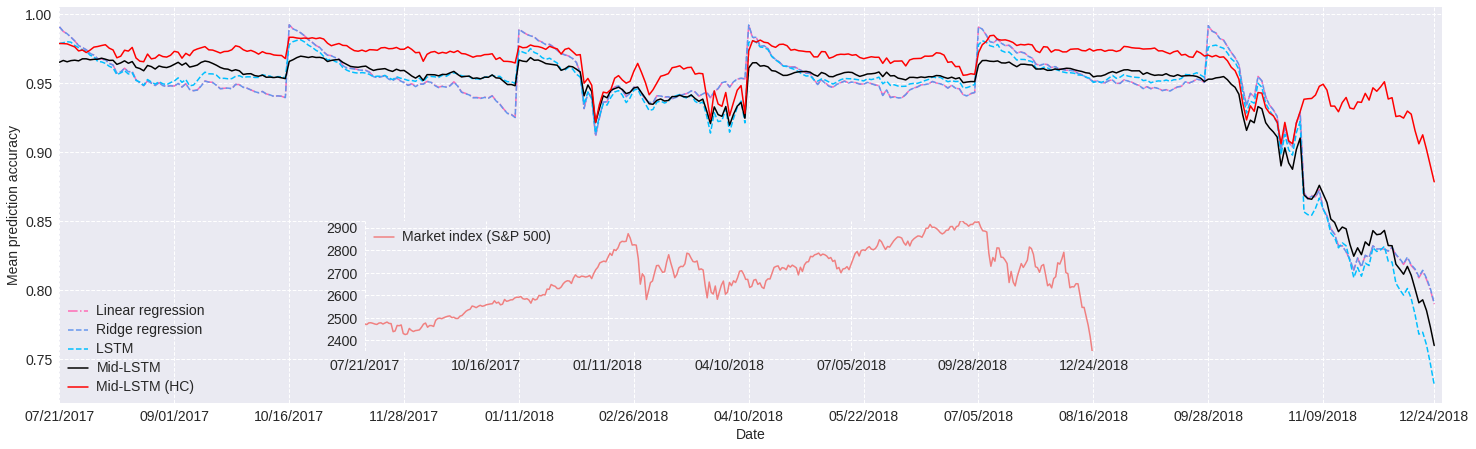

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

linear_a_451=np.load('linear_a_451.npy')
RF_a_451=np.load('RF_a_451.npy')
L1_a_451=np.load('L1_a_451.npy')
LH3pro_a_451=np.load('LH3pronew_a_451.npy')
LH3pro_a_50=np.load('LH3pronew_a_50.npy')
ridge_a_451=np.load('ridge_a_451.npy')

spy=pd.read_csv('spy_test.csv')

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,2.4,1.0
ax1 = fig.add_axes([left,bottom,width,height])

plt.grid(linestyle = "--")     

plt.plot(linear_a_451,color="hotpink",linestyle = "-.",label="Linear regression",linewidth=1.5)
plt.plot(ridge_a_451,color="cornflowerblue",linestyle = "--",label="Ridge regression",linewidth=1.5)
plt.plot(L1_a_451,color="deepskyblue",label="LSTM ",linestyle = "--",linewidth=1.5)
plt.plot(LH3pro_a_451,color="black",label="Mid-LSTM",linewidth=1.5)
plt.plot(LH3pro_a_50,color="red",label="Mid-LSTM (HC)",linewidth=1.5)

plt.yticks(fontsize=14)
plt.xlabel("Date",fontsize=14)
plt.ylabel("Mean prediction accuracy",fontsize=14)
plt.xlim(0,361)       
 
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=14) 
 
x=np.array([0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330., 359.])
group_labels=['07/21/2017','09/01/2017', '10/16/2017','11/28/2017', '01/11/2018',
              '02/26/2018', '04/10/2018','05/22/2018', '07/05/2018','08/16/2018',
              '09/28/2018','11/09/2018','12/24/2018']
plt.xticks(x,group_labels,fontsize=14,)

left, bottom, width, height = 0.63,0.23,1.27,0.33
ax2 = fig.add_axes([left,bottom,width,height])
ax2.plot(spy['spy'],color="lightcoral",label="Market index (S&P 500)",linewidth=1.5)

group_labels=['07/21/2017', '10/16/2017','01/11/2018',
               '04/10/2018','07/05/2018',
              '09/28/2018','12/24/2018']
x=np.arange(0, 365, 60.0)
plt.xticks(x,group_labels,fontsize=14,)
plt.yticks(fontsize=14,)
plt.grid(linestyle = "--") 
plt.xlim(0,361) 

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=14)

# plt.savefig('D:\\accuracy_spy_d21.jpg',dpi = 2000,bbox_inches='tight')
plt.margins(0,0)
plt.show()

###Figure 5: Mid-LSTM portfolio allocation: 09/28/2018-12/24/2018

In [0]:
LH_dph1=np.load('LH3pro_r_new.npy')
LH_dph1=pd.DataFrame(LH_dph1)
LH_dph1.columns = ['MSE','TRUE','accuracy','index','predict','stock']

LH_dph2=np.load('RF_r.npy')
LH_dph2=pd.DataFrame(LH_dph2)
LH_dph2.columns = ['MSE','TRUE','accuracy','index','predict','stock']

test_win=6
pre_len1=60
pre_len2=60
stock_len=451
rf=0.015

df_all=pd.DataFrame(columns=('index','return_pre','variance_pre','sharp_pre',
                            'return_true','variance_true','sharp_true',))

filename=np.load('filename_delete_sort.npy')
df = pd.DataFrame()

####cumulative
for k in range(5,test_win):
  n=stock_len
  
  for i in range(0,n):
    t2=LH_dph2['predict'][i][k*pre_len1:k*pre_len1+30]
    t1=LH_dph1['predict'][i][k*pre_len1+pre_len1-30:k*pre_len1+pre_len1]
    t2.extend(t1)
    t3=[]
    for j in range(0,pre_len1):
      t3.append(t2[j])
    t=t3
    df[filename[i]]=t  
  data1=df
  log_returns = np.log(data1 / data1.shift(1))
  ret_index = (1 + log_returns).cumprod()
  
  choose_name=[]
  choose_index=[]
  for i in range(0,n):
    if ret_index[filename[i]][59]>1.15:
      choose_name.append(filename[i])
      choose_index.append(i)
      
  #choose data
  m=len(choose_index)
  data2=data1.iloc[:,choose_index]
  log_returns = np.log(data2 / data2.shift(1))
  
  rets = log_returns
  year_ret = rets.mean() * 252
  year_volatility = rets.cov() * 252
  number_of_assets = m
  weights = np.random.random(number_of_assets)
  weights /= np.sum(weights)
  
  def statistics(weights):        
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])
  
  def min_func_sharpe(weights):
    return -statistics(weights)[2]
  
  bnds = tuple((0,1) for x in range(number_of_assets))
  cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

  opts = sco.minimize(min_func_sharpe, 
                      number_of_assets * [1. / number_of_assets,],
                      method='SLSQP', 
                      bounds=bnds, 
                      constraints=cons)
  
  weights_pre=opts['x']
  
  ##check return
  df2 = pd.DataFrame()
  for i in choose_index:
    t=LH_dph1['TRUE'][i][k*pre_len1:k*pre_len1+pre_len1]
    t1=[]
    for j in range(0,pre_len1):
      t1.append(t.iloc[j,][0])
    t= t1
    df2['ture'+filename[i]]=t
  data3=df2 
  log_returns_true = np.log(data3 / data3.shift(1))
  
  rets_true = log_returns_true
  year_ret_true = rets_true.mean() * 252
  year_volatility_true = rets_true.cov() * 252
  number_of_assets = m  #real asset number
  
  def statistics_true(weights):        
    weights = np.array(weights)
    pret = np.sum(rets_true.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets_true.cov() * 252, weights)))
    return np.array([pret, pvol, (pret-rf )/ pvol])
  
  index=k
  return_pre=statistics(opts['x'])[0]
  variance_pre=statistics(opts['x'])[1]
  sharp_pre=statistics(opts['x'])[2]
  return_true=statistics_true(opts['x'])[0]
  variance_true=statistics_true(opts['x'])[1]
  sharp_true=statistics_true(opts['x'])[2]
  
  df_all=df_all.append(pd.DataFrame({'index':[index],
                                     'return_pre':[return_pre],
                                     'variance_pre':[variance_pre],
                                     'sharp_pre':[sharp_pre],
                                     'return_true':[ return_true],
                                     'variance_true':[variance_true],
                                    'sharp_true':[sharp_true],}),ignore_index=True)

portfolio_returns = []
portfolio_volatilities = []
for p in range (800):
    weights = np.random.random(number_of_assets)
    weights /= np.sum(weights)
    portfolio_returns.append(np.sum(rets.mean() * weights) * 252)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
      
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

np.save('portfolio_volatilities.npy',portfolio_volatilities)
np.save('portfolio_returns.npy',portfolio_returns)

def statistics(weights):       
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, (pvol-rf), pret / pvol])
  
def mean_func_sharpe(weights):
    return -statistics(weights)[2]
  
def min_func_variance(weights):
  return statistics(weights)[1]
  
bnds = tuple((0,1) for x in range(number_of_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

opts = sco.minimize(mean_func_sharpe, 
                    number_of_assets * [1. / number_of_assets,],
                    method='SLSQP', 
                    bounds=bnds, 
                    constraints=cons)
optv = sco.minimize(min_func_variance, 
                    number_of_assets * [1. / number_of_assets,],
                    method='SLSQP', bounds=bnds, 
                    constraints=cons)

def min_func_port(weights):
    return statistics(weights)[1]  
  
target_returns = np.linspace(statistics(optv['x'])[0],
                             statistics(optv['x'])[0]+0.2,20)


target_volatilities = []
i=0
for tret in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, number_of_assets * [1. / number_of_assets,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    target_volatilities.append(res['fun'])
#     print(i)
    i=i+1
target_volatilities=np.array( target_volatilities)

np.save('target_volatilities.npy',target_volatilities)
np.save('target_returns.npy',target_returns)

[None, None, None, None, None, None, None, None]

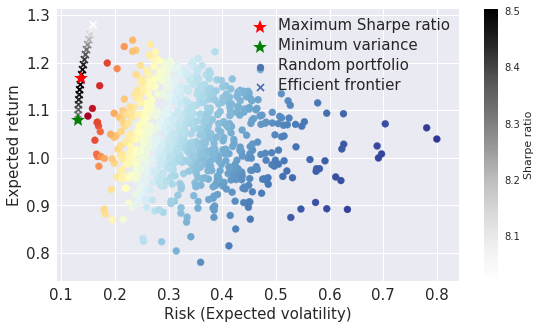

In [0]:
plt.rcParams['font.sans-serif']=['Arial']  
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(9, 5))
cm = plt.cm.get_cmap('RdYlBu_r')

plt.scatter(portfolio_volatilities, portfolio_returns,
            c=portfolio_returns / portfolio_volatilities,cmap=cm, marker='o',
           label="Random portfolio")
          
plt.scatter(target_volatilities, target_returns,
            c=target_returns / target_volatilities, marker='x',
           label="Efficient frontier")
         
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0,label="Maximum Sharpe ratio")
         
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'g*', markersize=15.0,label="Minimum variance")
            
plt.grid(True)
plt.xlabel('Risk (Expected volatility)',fontsize=15)
plt.ylabel('Expected return',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,)
plt.colorbar(label='Sharpe ratio')
plt.rcParams['font.size'] =15

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15)